In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Markdown

import notebooks.config as config
import notebooks.utils as nb_utils
from src.features.multivariate_analysis import MACleaner
from src.features.utils import get_anova_importance_scores
from src.utils import Dataset, Metadata, preprocess_init

STAGE = 2
PREVIOUS_STAGE = STAGE - 1

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata from artifacts

In [2]:
df, metadata = nb_utils.load_artifacts(PREVIOUS_STAGE)

## Multivariate Analysis

### Renovated cars

In [3]:
@preprocess_init
def ma_renovated_cars(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    renovated_cars = df.loc[
        df.o_Restauriran,
        [
            "name",
            "gi_production_year",
            "price",
            "short_url",
            "gi_kilometerage",
            "gi_engine_capacity",
            "gi_engine_power",
            "ai_seats_no",
            "o_Restauriran",
            "o_Oldtimer",
        ],
    ]

    renovated_pairplot = sns.pairplot(data=renovated_cars.drop(columns="o_Oldtimer"))
    plt.close()
    print("Renovated cars pairplot")
    display(renovated_pairplot.figure)
    print()

    fig, ax = plt.subplots(1, 2)

    sns.kdeplot(df, x="price", hue="o_Restauriran", common_norm=False, ax=ax[0])
    sns.histplot(
        df,
        x="price",
        stat="probability",
        hue="o_Restauriran",
        common_norm=False,
        ax=ax[1],
    )
    plt.close()

    print(f"'{config.LABEL}' by 'o_Restauriran'")
    display(fig)
    print()

    display(
        Markdown(
            "Nothing can be extracted from these plots because the sample size for true is too small."
        )
    )
    print()

    print("Show countplot of renovated cars by 'o_Oldtimer' feature")
    sns.countplot(renovated_cars, x="o_Oldtimer", hue="o_Restauriran", legend=False)

    return df, metadata

Renovated cars pairplot


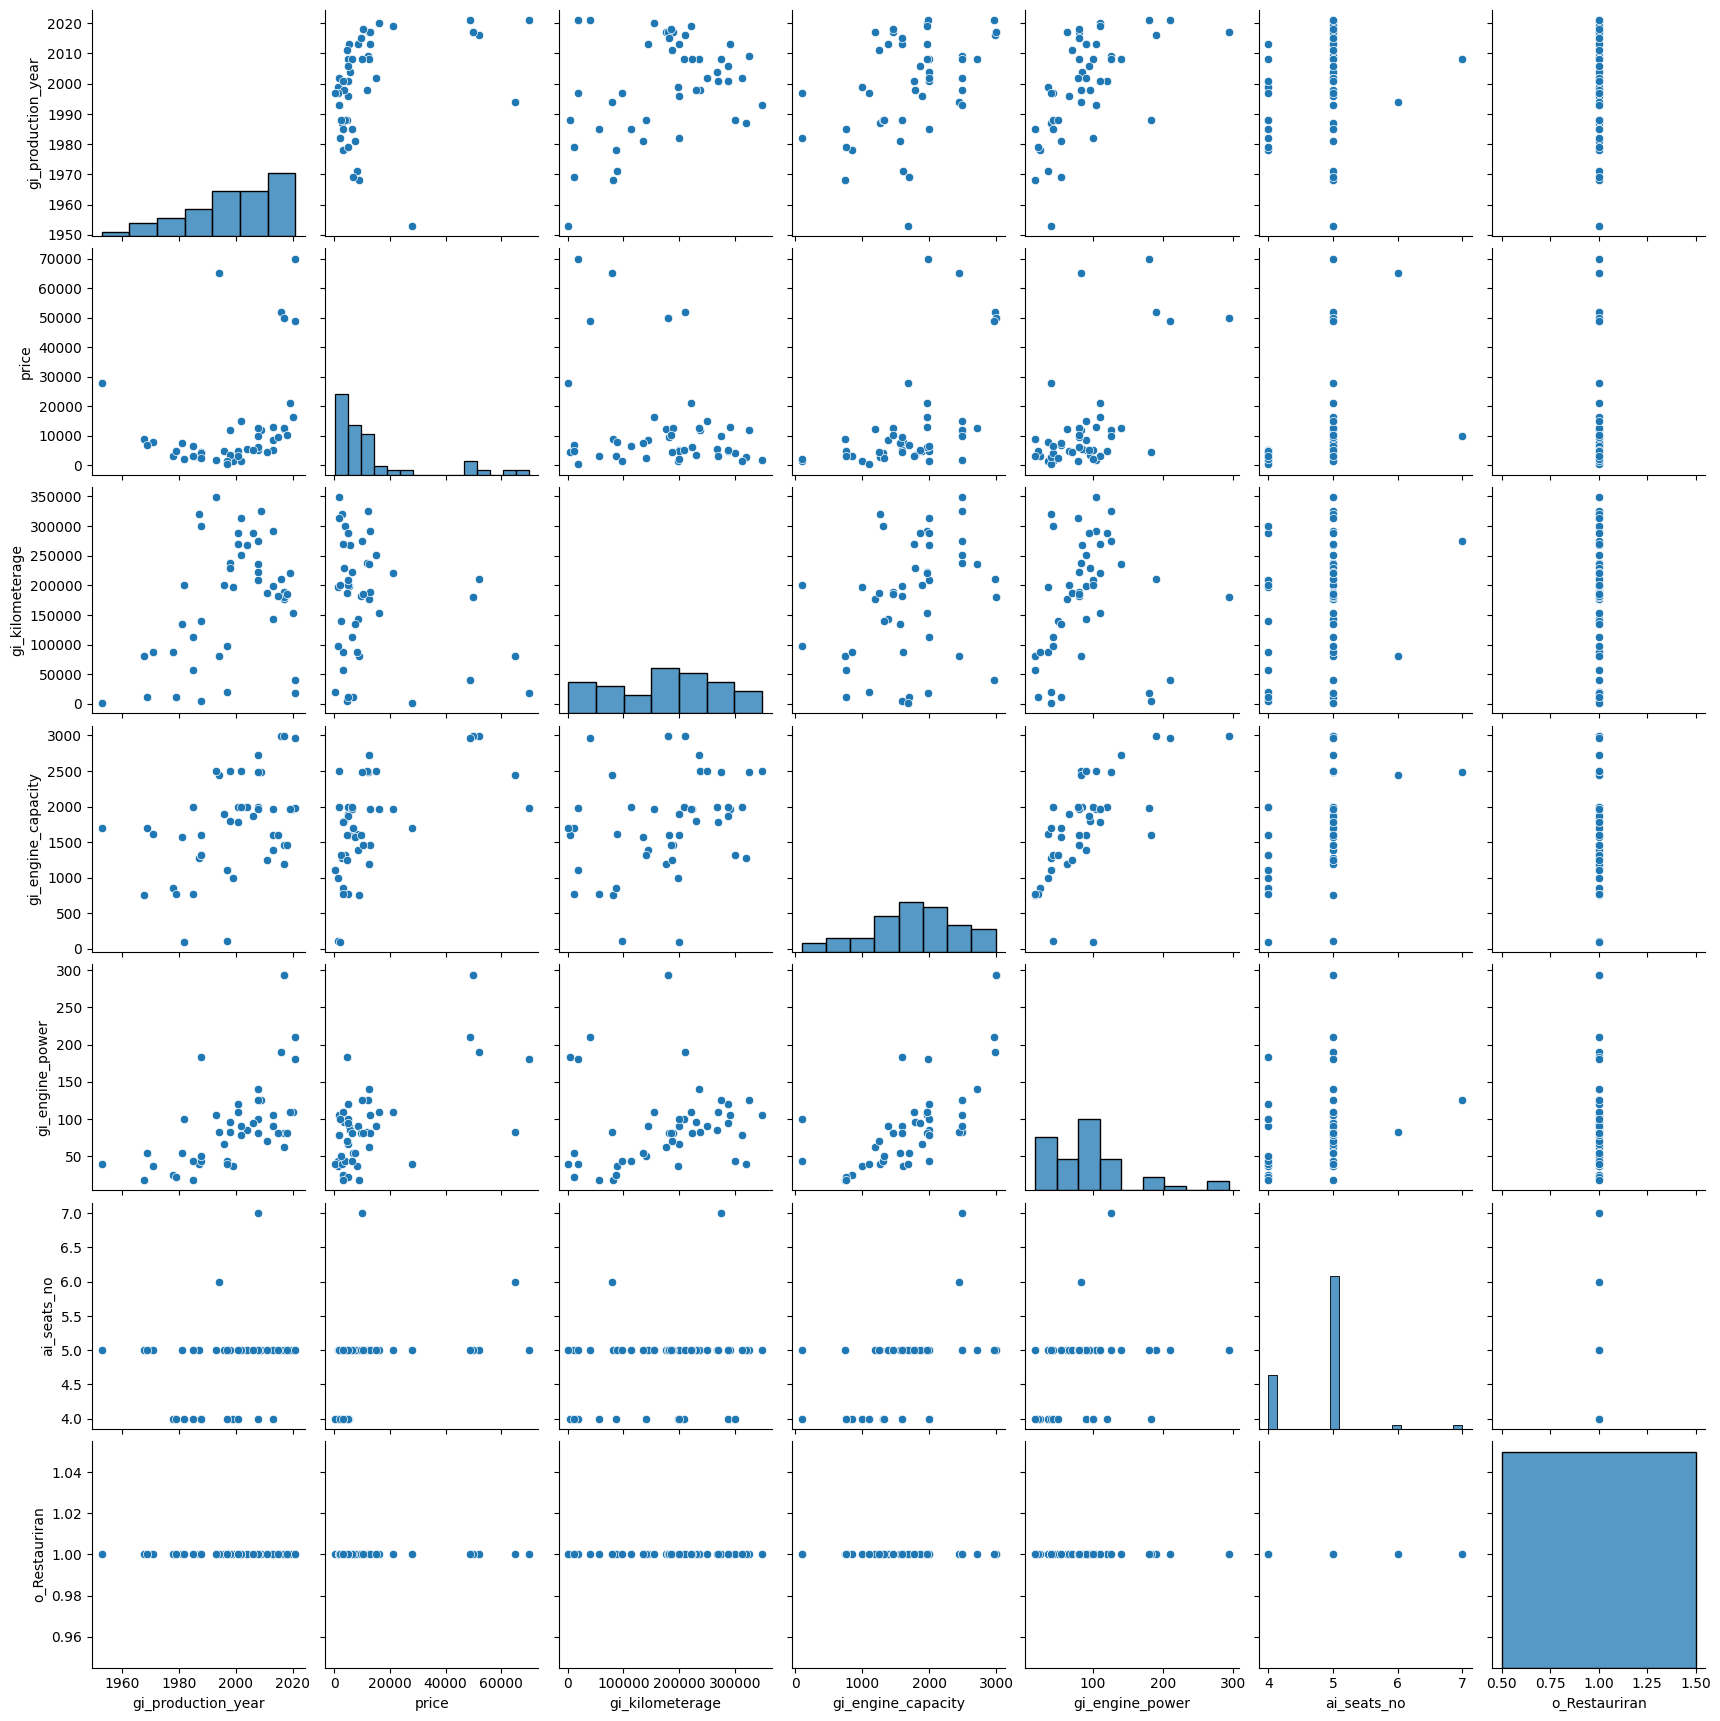


'price' by 'o_Restauriran'


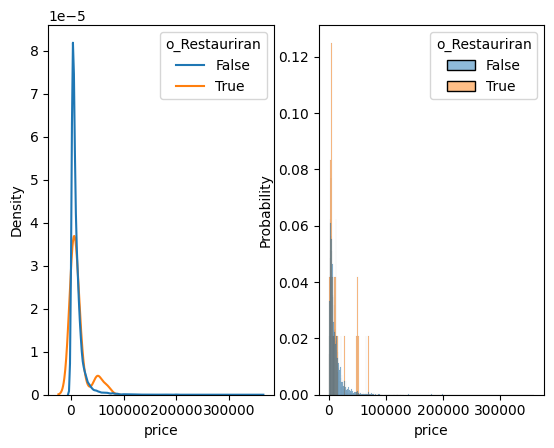

Nothing can be extracted from these plots because the sample size for true is too small.


Show countplot of renovated cars by 'o_Oldtimer' feature


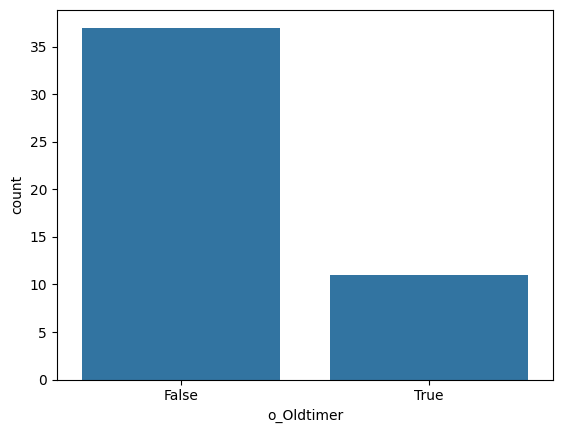

In [4]:
df, metadata = ma_renovated_cars(df=df, metadata=metadata)

### Correlations

#### Numerical columns

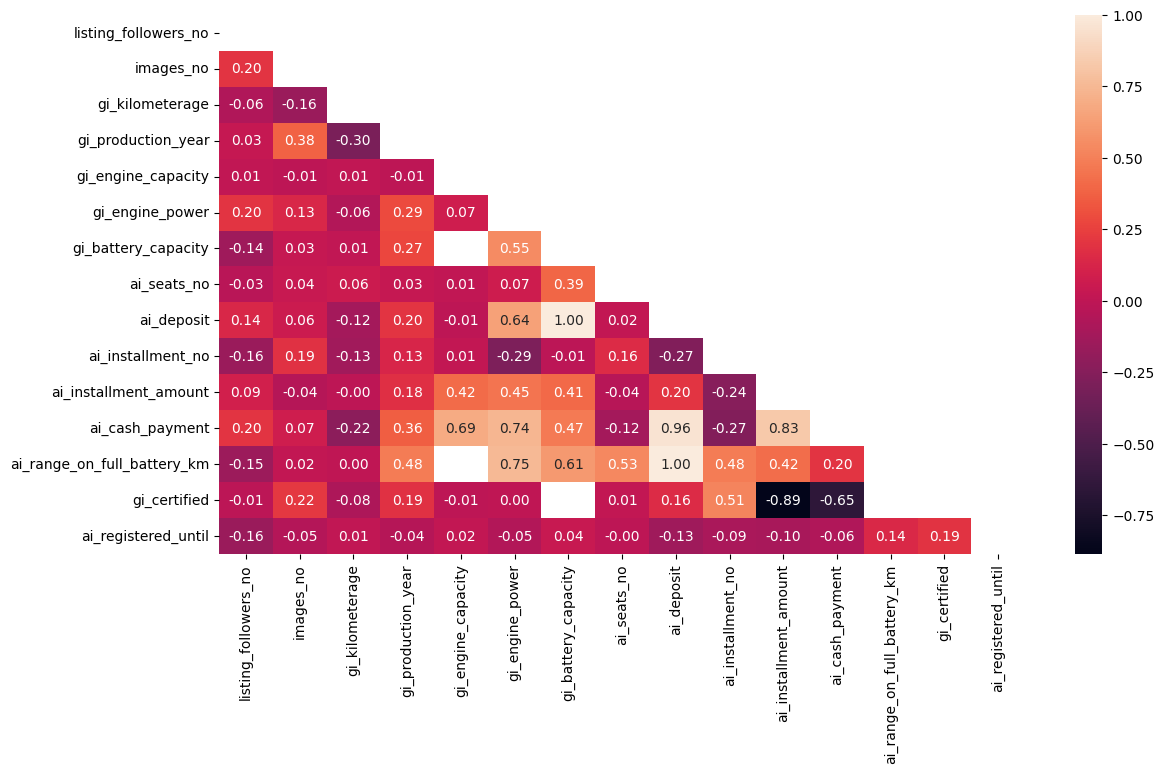

In [5]:
corr_numerical = df[metadata.features_info["numerical"]].corr()
nb_utils.plot_correlation_heatmap(corr=corr_numerical);

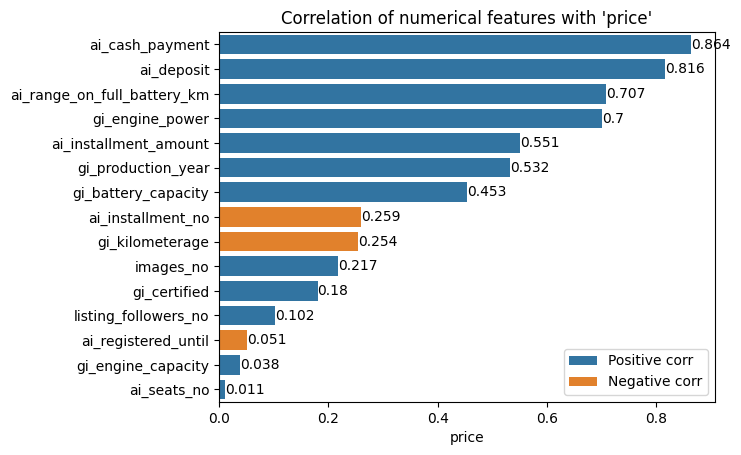

In [6]:
corr_numerical_and_label = df[metadata.features_info["numerical"] + [config.LABEL]].corr()
corr_numerical_with_label = (
    corr_numerical_and_label[config.LABEL]
    .drop(config.LABEL)
    .sort_values(key=lambda x: abs(x), ascending=False)
)

colors = [
    "Positive corr" if val > 0 else "Negative corr" for val in corr_numerical_with_label
]
nb_utils.plot_bar_correlations(
    corr=corr_numerical_with_label.round(3), colors=colors, by=config.LABEL
);

### Feature importance

#### Safety columns

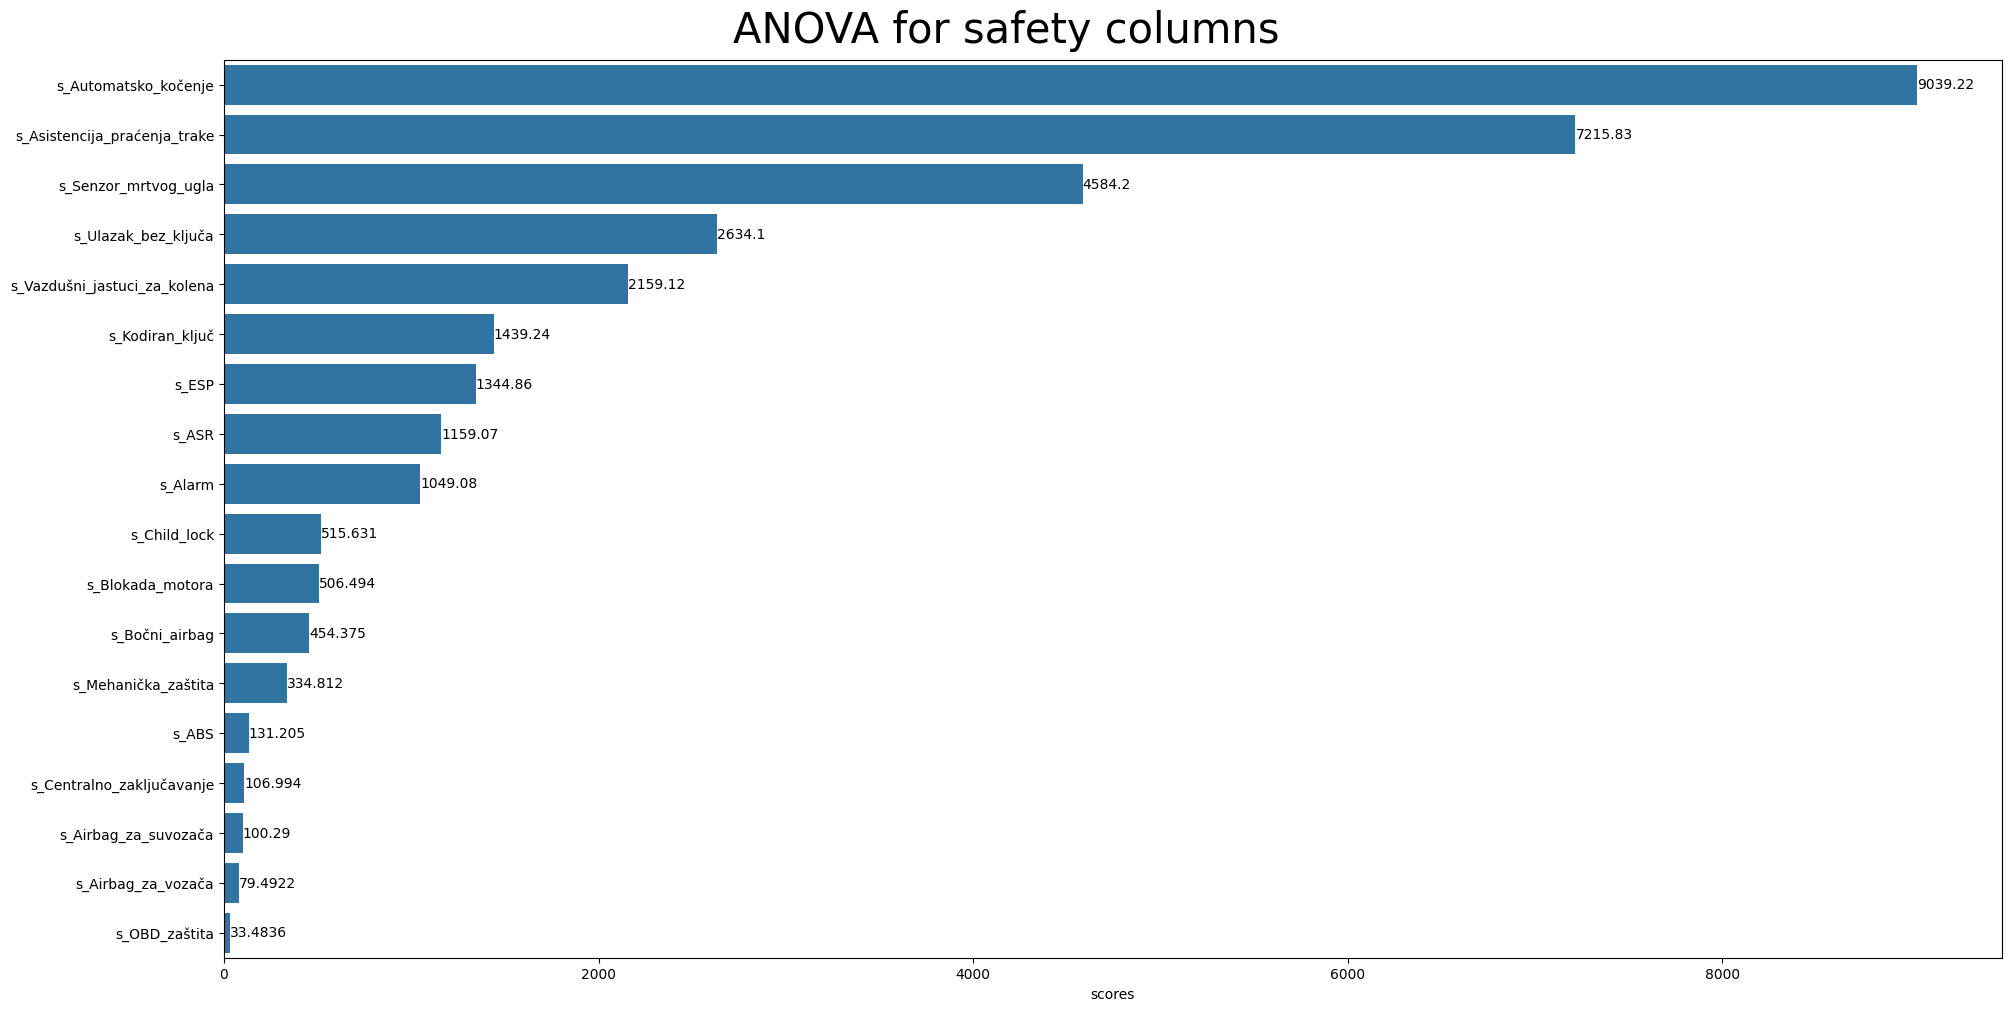

In [7]:
safety_columns = [
    col for col in metadata.features_info["binary"] if col.startswith("s_")
]

anova_scores = get_anova_importance_scores(X=df[safety_columns], y=df[config.LABEL])
nb_utils.plot_anova_importance(anova_scores, "ANOVA for safety columns");

#### Equipment columns

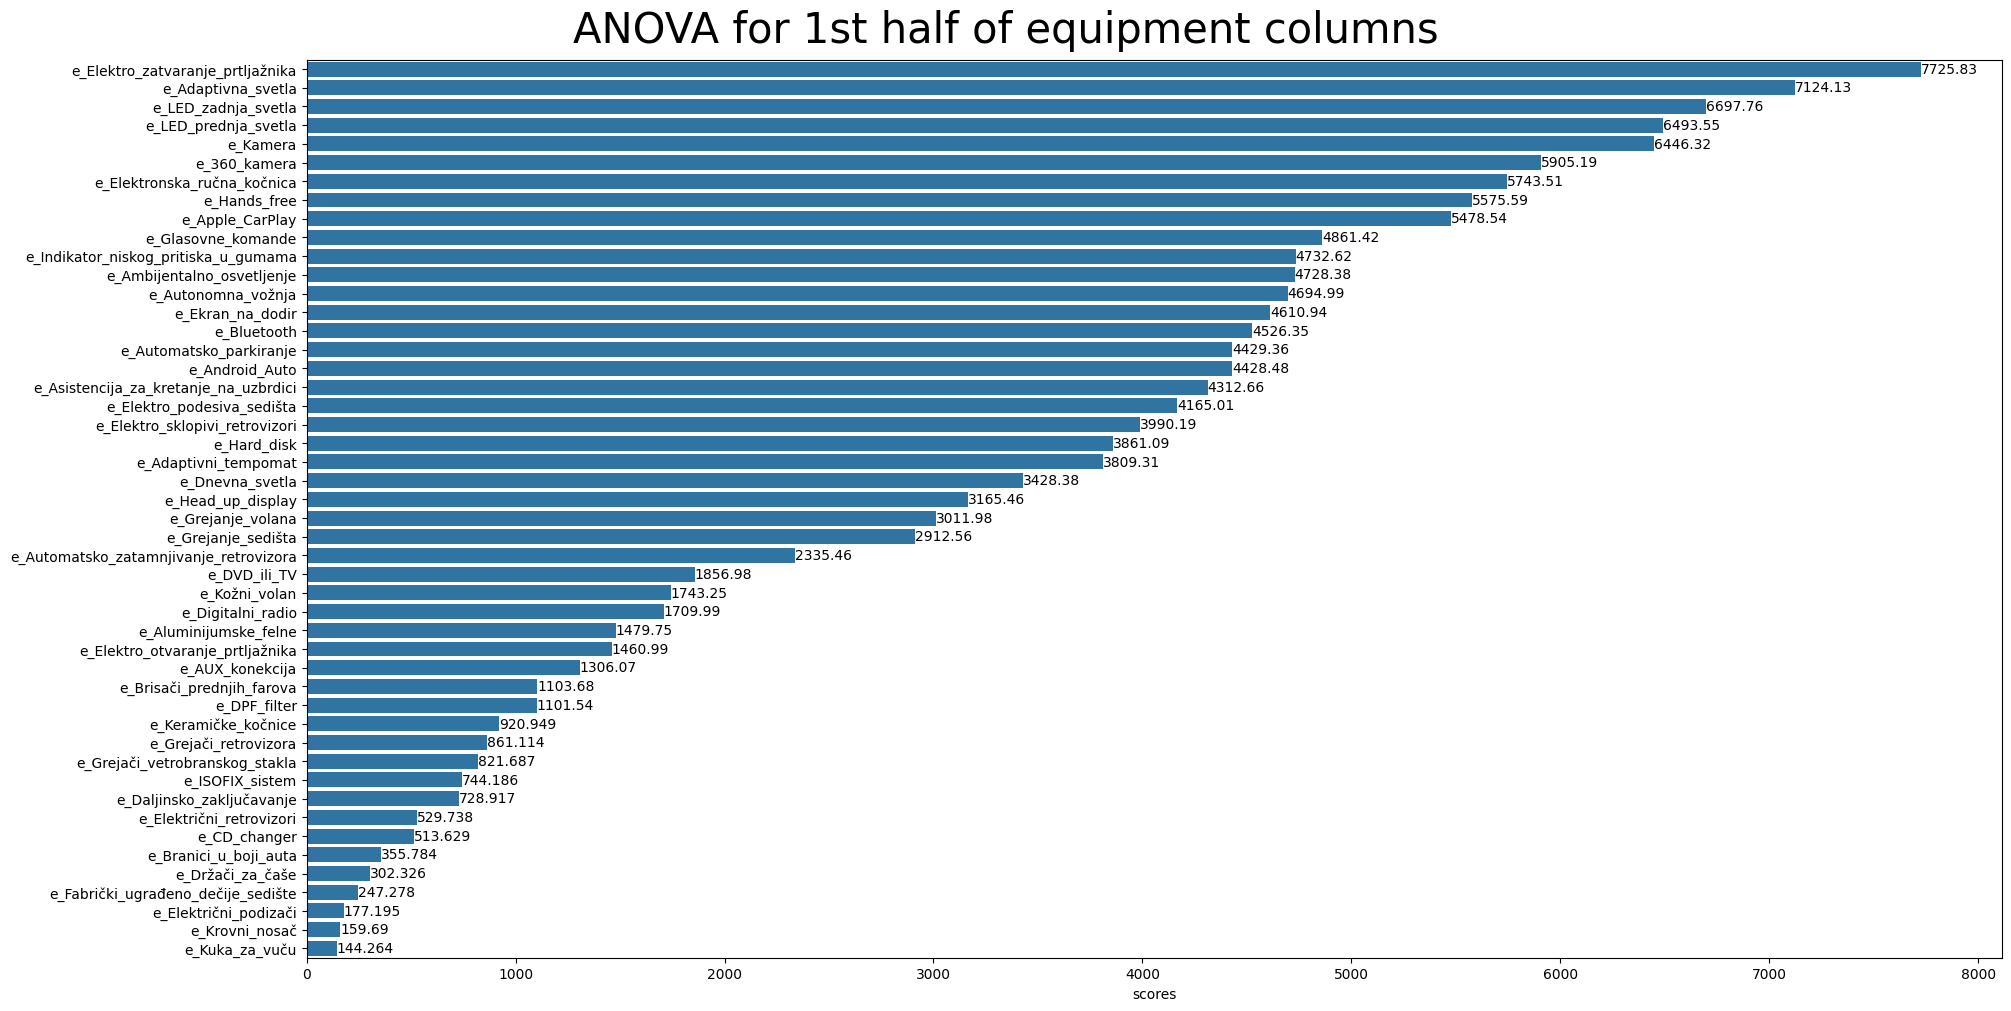

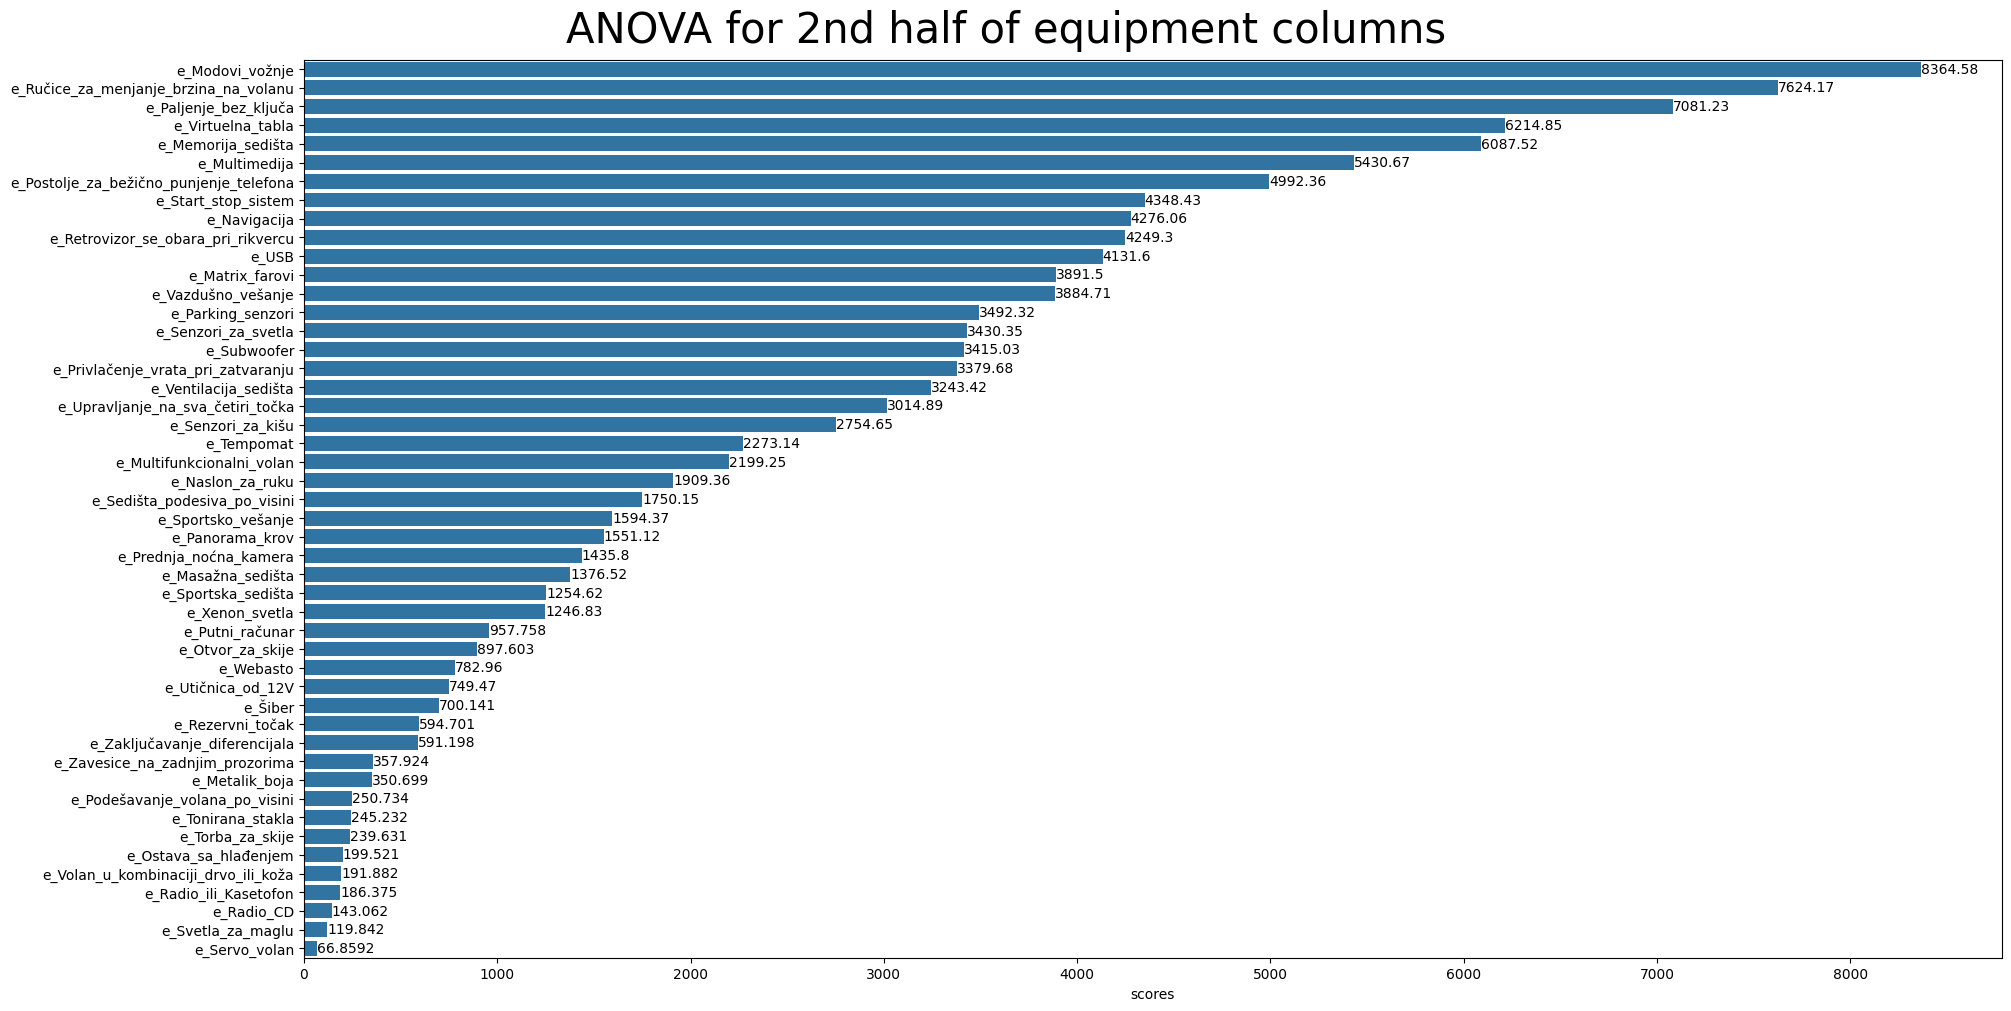

In [8]:
equipment_columns = [
    col for col in metadata.features_info["binary"] if col.startswith("e_")
]

equipment_columns_1_half = equipment_columns[: len(equipment_columns) // 2]
equipment_columns_2_half = equipment_columns[len(equipment_columns) // 2 + 1 :]

fig, (ax_1, ax_2) = plt.subplots(1, 2)

anova_scores_1 = get_anova_importance_scores(
    X=df[equipment_columns_1_half], y=df[config.LABEL]
)
anova_scores_2 = get_anova_importance_scores(
    X=df[equipment_columns_2_half], y=df[config.LABEL]
)

ax_1 = nb_utils.plot_anova_importance(
    anova_scores_1, "ANOVA for 1st half of equipment columns"
)
ax_2 = nb_utils.plot_anova_importance(
    anova_scores_2, "ANOVA for 2nd half of equipment columns"
)
plt.close()

#### Other columns

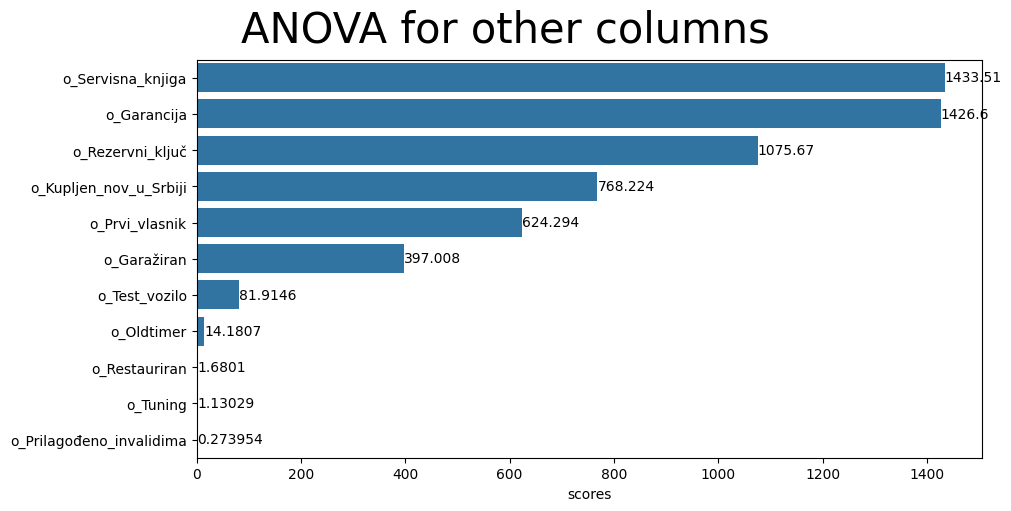

In [9]:
other_columns = [
    col for col in metadata.features_info["binary"] if col.startswith("o_")
]

anova_scores = get_anova_importance_scores(X=df[other_columns], y=df[config.LABEL])
nb_utils.plot_anova_importance(anova_scores, "ANOVA for other columns", figsize=(10, 5));

### Finalize processing

Since 'gi_battery_capacity' column has +0.425 correlation with 'price', that means it can benefit to the model, but the important thing we need to have in mind is that over 100 cars had values for 'gi_battery_capacity' feature.
<br><br>
Similar for 'ai_range_on_full_battery_km', where correlation is +0.669.
<br><br>
'ai_seats_no' shows almost 0 correlation, which is kind of weird. We would except cars that have more seats to be at least somewhat more expensive.

In [10]:
@preprocess_init
def ma_finalize(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    features_info["features_to_delete"].remove("gi_battery_capacity")
    features_info["features_to_delete"].remove("ai_range_on_full_battery_km")

    cols_nan_strategy["const_0"].extend(
        ["gi_battery_capacity", "ai_range_on_full_battery_km"]
    )

    nominal_to_delete = ["location", "gi_brand", "gi_model"]
    features_info["features_to_delete"].extend(nominal_to_delete)
    print(f"Excluded nominal features that have too big cardinality at the moment:\n{nominal_to_delete}")

    return df, metadata

In [11]:
df, metadata = ma_finalize(df=df, metadata=metadata)

Excluded nominal features that have too big cardinality at the moment:
['location', 'gi_brand', 'gi_model']


## Testing

### Test individual components

In [12]:
def get_func_from_globals(func: Callable) -> Callable:
    result_func_name: str = func.__name__
    result_func: Callable = globals()[result_func_name]

    if not callable(result_func):
        raise Exception(
            f"Provided function {func.__name__} is not a function in globals."
        )
    return result_func


class TestNotebook(nb_utils.TestNotebookGeneric):
    def test_single_funcs(self):
        transf_obj: MACleaner = self.transformer_obj  # type: ignore
        df_prep, metadata_prep = nb_utils.load_artifacts(PREVIOUS_STAGE)

        all_funcs_to_test: list[Callable] = [transf_obj.ma_finalize]

        for func_to_test in all_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep,
                metadata=metadata_prep,
            )

    def test_whole_component(self, df_nb: Dataset, metadata_nb: Metadata):
        df_init_py, metadata_init_py = nb_utils.load_artifacts(PREVIOUS_STAGE)
        self._test_whole_component_complex(
            df_init_py, metadata_init_py, df_nb, metadata_nb
        )

In [ ]:
test_obj = TestNotebook(MACleaner())
test_obj.test_single_funcs()

### Test whole component

In [14]:
test_obj.test_whole_component(df_nb=df, metadata_nb=metadata)

## Save cleaned data and metadata in artifacts

In [15]:
nb_utils.save_artifacts(STAGE, df, metadata)